<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/ANN_for_airline_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv


--2024-07-27 08:50:23--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-07-27 08:50:24 (23.8 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = pd.read_csv('airline.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.shape

(144, 1)

In [ ]:
df.isnull().sum()

Passengers    0
dtype: int64

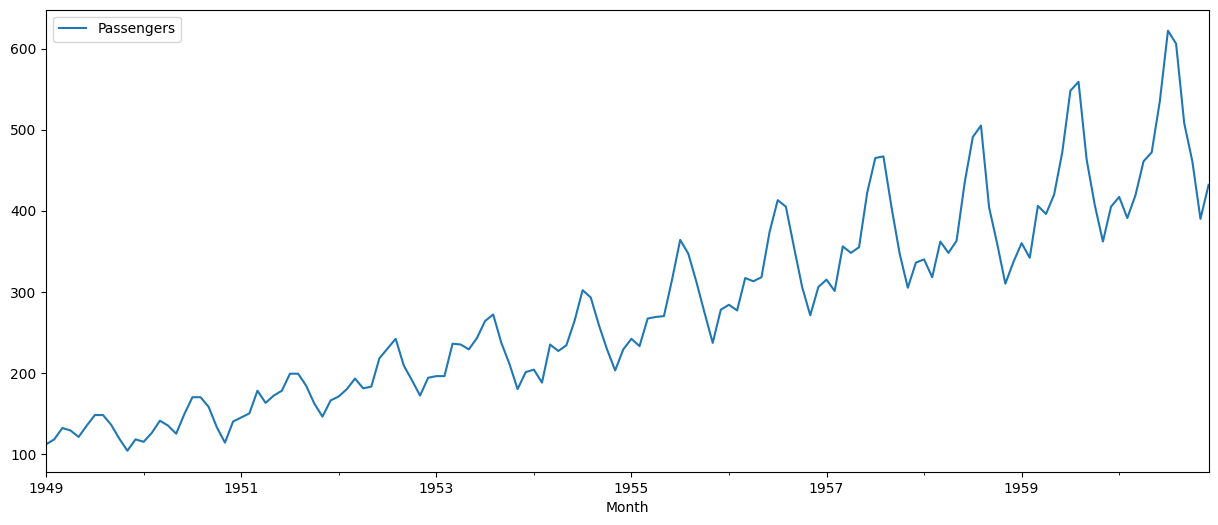

In [ ]:
df.plot(figsize=(15,6));

In [ ]:
df['logPassengers'] = np.log(df['Passengers'])

In [ ]:
N_test = 12
train = df[:-N_test]
test = df[-N_test:]

In [ ]:
train.shape, test.shape

((132, 2), (12, 2))

We are going to train on differenced data now

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['logPassengers'].diff()

Let's make our data set for one step forecast

In [ ]:
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 # 10 previous lags
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)


(133, 10)
(133,)


In [ ]:
X_train, X_test = X[:-N_test], X[-N_test:]
Y_train, Y_test = Y[:-N_test], Y[-N_test:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(121, 10)
(12, 10)
(121,)
(12,)


#### Let's Make our first ANN Model

In [ ]:
i = Input((T,))
x = Dense(16, activation='relu')(i)
x = Dense(1, activation='linear')(x) # Here we choose 1 because of 1 step forecast and activation linear because we linearly want to predict.

model = Model(i, x)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
r = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 74ms/step - loss: 0.0194 - mae: 0.1213 - val_loss: 0.0148 - val_mae: 0.1024
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0172 - mae: 0.1141 - val_loss: 0.0133 - val_mae: 0.0949
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0156 - mae: 0.1085 - val_loss: 0.0123 - val_mae: 0.0903
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0144 - mae: 0.1033 - val_loss: 0.0115 - val_mae: 0.0876
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0134 - mae: 0.0990 - val_loss: 0.0111 - val_mae: 0.0852
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0128 - mae: 0.0954 - val_loss: 0.0108 - val_mae: 0.0830
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0122 - mae: 0.0924 - val_loss: 0.0105 - val_mae: 0.0810
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0117 - mae: 0.08

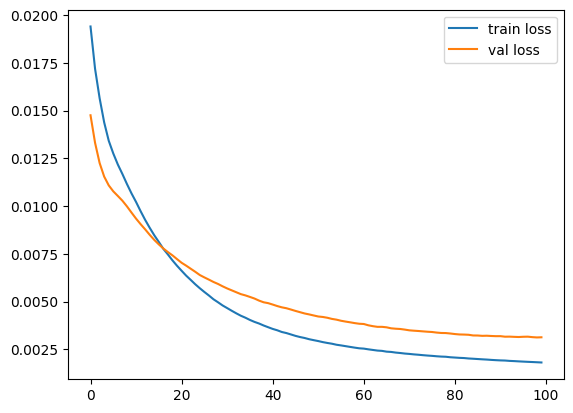

In [ ]:
# Let's plot the train and loss plots.
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

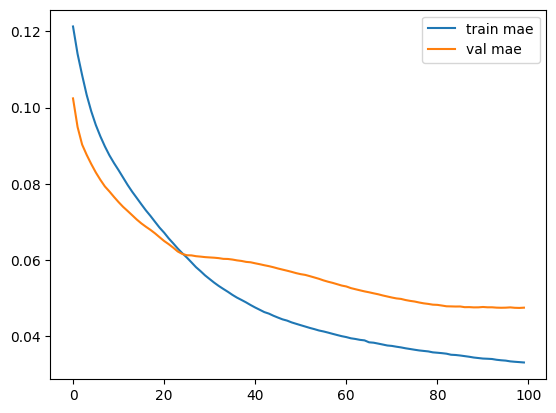

In [ ]:
plt.plot(r.history['mae'], label='train mae')
plt.plot(r.history['val_mae'], label='val mae')
plt.legend();

In [ ]:
train_idx[:T+1] = False

In [ ]:
P_train = model.predict(X_train).flatten()
P_test = model.predict(X_test).flatten()

1/1 [==============================] - 0s 21ms/step


In [ ]:
df.loc[train_idx, 'Diff ANN 1step Forecast Train'] = P_train
df.loc[test_idx, 'Diff ANN 1step Forecast Test'] = P_test

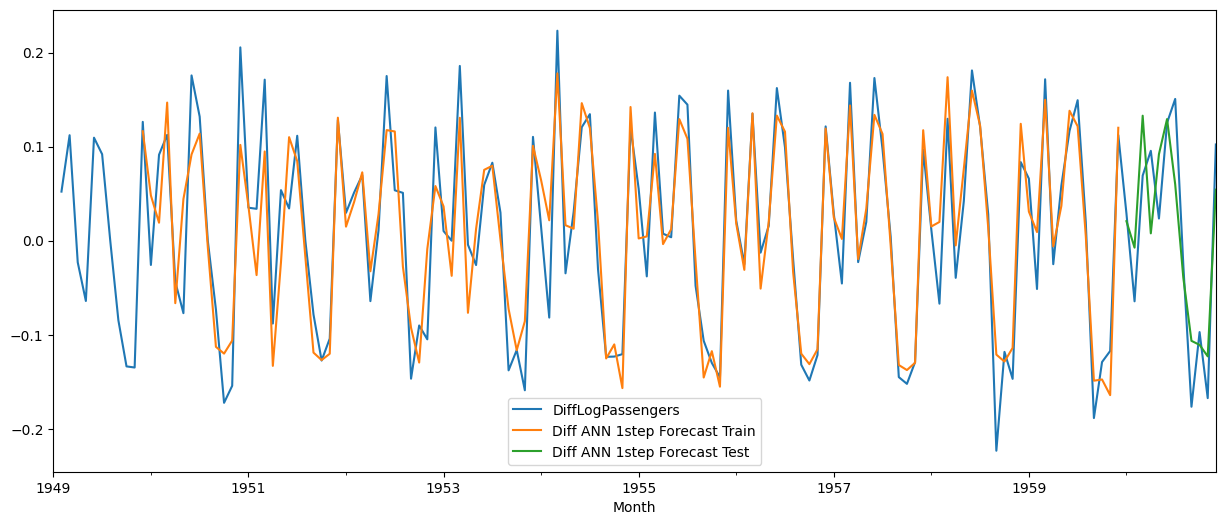

In [ ]:
# Let's plot
df[['DiffLogPassengers', 'Diff ANN 1step Forecast Train', 'Diff ANN 1step Forecast Test']].plot(figsize=(15,6));

In [ ]:
df['ShiftLogPassengers'] = df['logPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
# Last Know train value
last_train = train.iloc[-1]['logPassengers']

In [ ]:
prev[train_idx].shape

(121,)

In [ ]:
P_train.shape

(121,)

In [ ]:
df.loc[train_idx, '1step forecast train'] = prev[train_idx] + P_train
df.loc[test_idx, '1step forecast test'] = prev[test_idx] + P_test


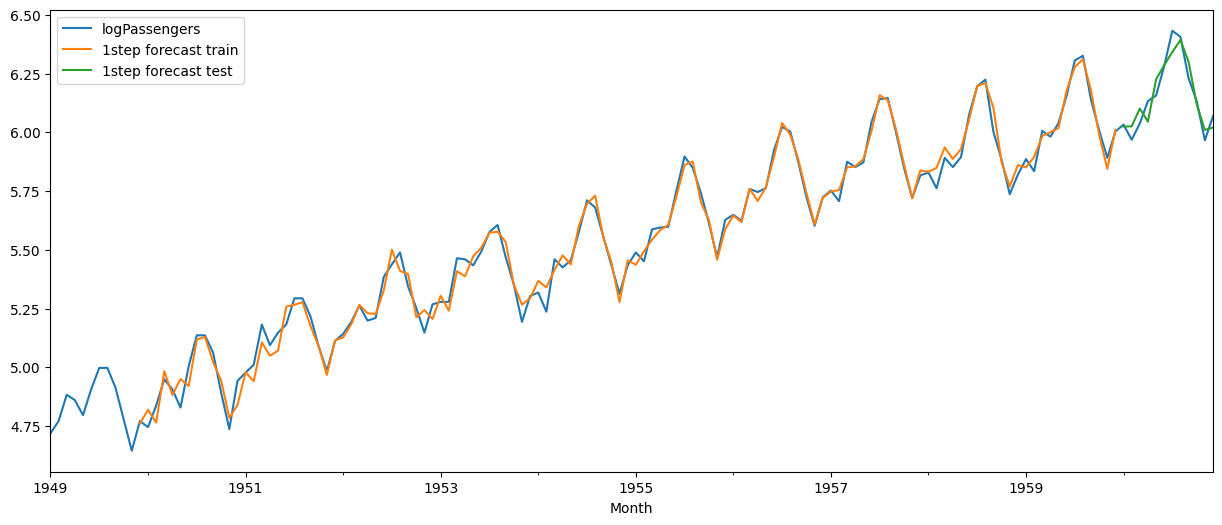

In [ ]:
# Let's plot
df[['logPassengers', '1step forecast train', '1step forecast test']].plot(figsize=(15,6));

It is good but not as good <br>
### Let's try now multi step forecast

In [ ]:
multistep_predictions = []

last_x = X_test[0]

while len(multistep_predictions) < N_test:
  p = model.predict(last_x.reshape(1, -1))[0]
  multistep_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 51ms/step


<ipython-input-47-178717beea66>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 [==============================] - 0s 22ms/step


In [ ]:
multistep_predictions = np.array(multistep_predictions)
multistep_predictions.shape

(12, 1)

In [ ]:
df.loc[test_idx, 'multistep_forecast'] = last_train + np.cumsum(multistep_predictions)

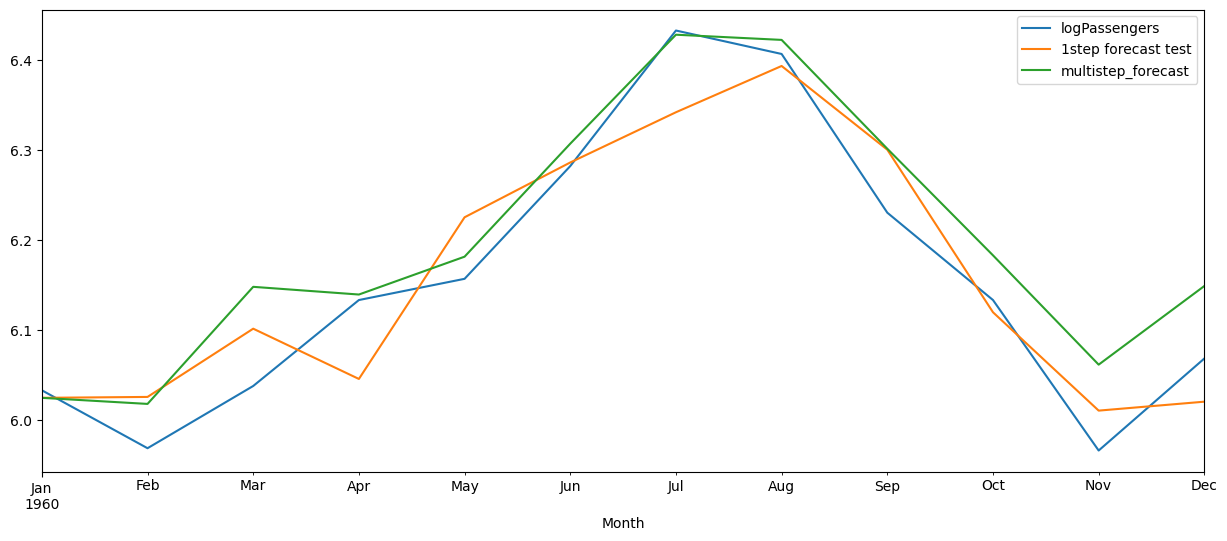

In [ ]:
# Let's Plot
df[['logPassengers', '1step forecast test', 'multistep_forecast']][-N_test:].plot(figsize=(15,6));

#### Let's have multi output supervised dataset

In [ ]:
Tx = T
Ty = N_test
X, Y = [],[]

for t in range(len(series) - Tx - Ty + 1):
  x = series[t: t + Tx]
  X.append(x)
  y = series[t + Tx: t + Tx + Ty]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(122, 10)
(122, 12)


In [ ]:
X_train_m, X_test_m = X[:-1], X[-1:]
Y_train_m, Y_test_m = Y[:-1], Y[-1:]

In [ ]:
print(X_train_m.shape, Y_train_m.shape)
print(X_test_m.shape, Y_test_m.shape)

(121, 10) (121, 12)
(1, 10) (1, 12)


In [ ]:
i = Input(shape=(Tx))
x = Dense(32, activation='relu')(i)
x = Dense(Ty, activation='linear')(x)

model = Model(i, x)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
r = model.fit(X_train_m, Y_train_m, validation_data=(X_test_m, Y_test_m), epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 60ms/step - loss: 0.0139 - mae: 0.0986 - val_loss: 0.0095 - val_mae: 0.0812
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0129 - mae: 0.0951 - val_loss: 0.0088 - val_mae: 0.0779
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0121 - mae: 0.0921 - val_loss: 0.0083 - val_mae: 0.0748
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0114 - mae: 0.0893 - val_loss: 0.0079 - val_mae: 0.0721
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0108 - mae: 0.0870 - val_loss: 0.0075 - val_mae: 0.0695
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0103 - mae: 0.0848 - val_loss: 0.0071 - val_mae: 0.0671
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0099 - mae: 0.0829 - val_loss: 0.0069 - val_mae: 0.0650
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0095 - mae: 0.08

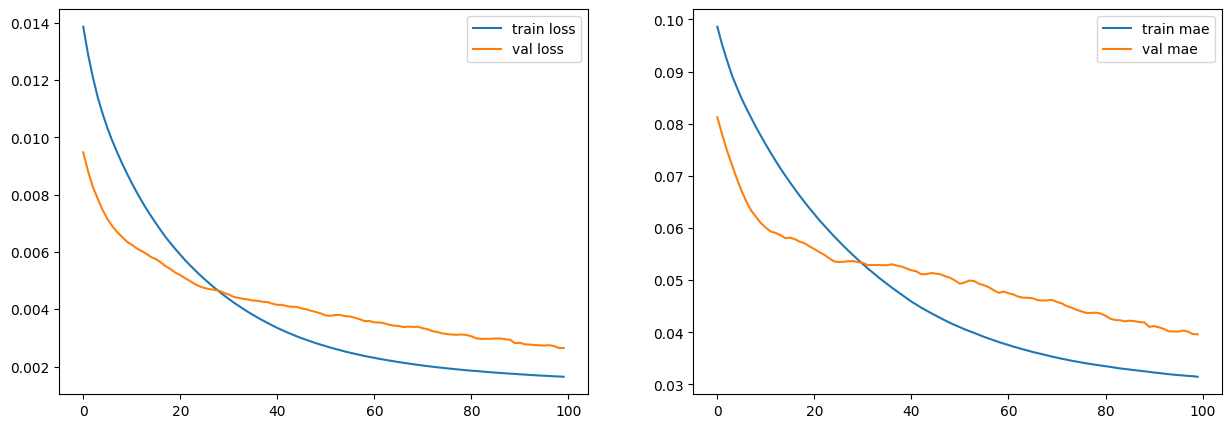

In [ ]:
# Let's plot the loss and accuracy graphs
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].legend()

ax[1].plot(r.history['mae'], label='train mae')
ax[1].plot(r.history['val_mae'], label='val mae')
ax[1].legend();


In [ ]:
P_train = model.predict(X_train_m)
P_test = model.predict(X_test_m)

1/1 [==============================] - 0s 20ms/step


In [ ]:
print(P_train.shape)
print(P_test.shape)

(121, 12)
(1, 12)


In [ ]:
P_train = P_train[:,0]
P_test = P_test[0]

In [ ]:
df.loc[test_idx, 'multistep_multioutput_forecast'] = last_train + np.cumsum(P_test)

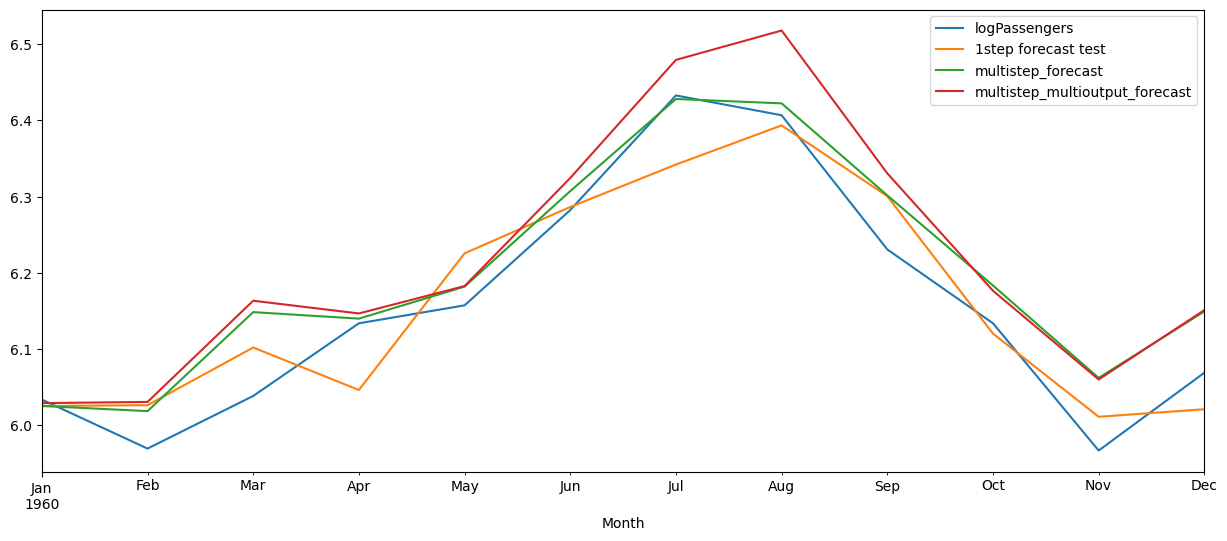

In [ ]:
# Let's plot
df[['logPassengers', '1step forecast test', 'multistep_forecast', 'multistep_multioutput_forecast']][-N_test:].plot(figsize=(15,6));

As all lines are conjusted, wo we will see from mape metrics that which one has done better job

In [ ]:
mape_1step = mean_absolute_percentage_error(df.loc[test_idx, 'logPassengers'], df.loc[test_idx, '1step forecast test'])
mape_multistep = mean_absolute_percentage_error(df.loc[test_idx, 'logPassengers'], df.loc[test_idx, 'multistep_forecast'])
mape_multistep_multioutput = mean_absolute_percentage_error(df.loc[test_idx, 'logPassengers'], df.loc[test_idx, 'multistep_multioutput_forecast'])

print(f'mape_1step: {mape_1step}')
print(f'mape_multistep: {mape_multistep}')
print(f'mape_multistep_multioutput: {mape_multistep_multioutput}')

mape_1step: 0.0077106415126034535
mape_multistep: 0.007399802789043885
mape_multistep_multioutput: 0.010134813153304436


So we can see that multistep is a good one